# Creating a GeoDataFrame from a CSV file

We are going to use `geopandas` `pandas` `shapely` and `matplotlib` to create and visualize a `GeoDataFrame`

In [ ]:
! conda install -c conda-forge geopandas

In [1]:
# read in our packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

%matplotlib inline

In [2]:
data = pd.read_csv("ride_data.csv", index_col=["time"], parse_dates=True)
# read in the data and use the time column as a datetime index

To create a `GeoDataFrame` we first need to create a geometry column. To do that we take the `data.longitude` and `data.latitude` and `zip` them together in a list. We then create a point using the shapely `Point` [constructor](https://shapely.readthedocs.io/en/stable/manual.html#points) and add it to the `geometry` list. Next, we remove the `latitude` `longitude` and `distance` columns from our data frame since we no longer need them. Then we create a dictionary with our Coordinate Reference Systems (CRS). Here we are using the WGS 84 reference system. 

Last all we need to do is call the `geopandas` `GeoDataFrame` on our `DataFrame`, `crs` dictionary, and `geometry` list to create our spatial data frame

In [3]:
# create our geometry list from the latitude and longitude
geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
# drop our columns that we no longer need
data = data.drop(["longitude", "latitude", "distance", "Unnamed: 0"], axis=1)
# set our CRS dictionary
crs = {"init": "epsg:4326"}
# one line call to create our GeoDataFrame
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

Double check to make sure it worked well and we can see the longitude and latitude in the `geometry` column

In [4]:
gdf.head()

,elevation,heart,slope,geometry
time,,,,
2018-09-29 13:49:47+00:00,1917.9,128,1.0,POINT (-111.372203 44.424087)
2018-09-29 14:02:38+00:00,1918.9,162,0.5,POINT (-111.372179 44.420219)
2018-09-29 14:02:41+00:00,1919.4,162,0.1,POINT (-111.372025 44.419968)
2018-09-29 14:02:42+00:00,1919.5,163,0.1,POINT (-111.372062 44.419922)
2018-09-29 14:02:43+00:00,1919.6,163,0.2,POINT (-111.372071 44.41986)


Now let's convert it to a different CRS so we can have our data projected in meters. this is a one liner, we use `.to_crs` along with a string containing our projection, ellipse, datum, and units to reproject the data.

In [5]:
gdf_m = gdf.to_crs(
    "+proj=utm +zone=12 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
)

Double check the geometry column is no longer in decimal degrees

In [6]:
gdf_m.head()

,elevation,heart,slope,geometry
time,,,,
2018-09-29 13:49:47+00:00,1917.9,128,1.0,POINT (470372.326700983 4919044.365244503)
2018-09-29 14:02:38+00:00,1918.9,162,0.5,POINT (470372.2836689437 4918614.71424212)
2018-09-29 14:02:41+00:00,1919.4,162,0.1,POINT (470384.4163059747 4918586.778427571)
2018-09-29 14:02:42+00:00,1919.5,163,0.1,POINT (470381.4476438793 4918581.682316032)
2018-09-29 14:02:43+00:00,1919.6,163,0.2,POINT (470380.6998837403 4918574.798857593)


The geometry is now in UTM so we can get things like distance in meters from the `GeoDataFrame`. To do that we get the `geometry` column and use `.distance()` on the `geometry` column shifted down one row. Then we fill in the `NaN` values with zero.

In [7]:
gdf_m["distance_m"] = (
    gdf_m.geometry.distance(gdf_m.geometry.shift(1)).copy().fillna(0)
)

We can also get the time difference from the `datetimeindex` in seconds, to do this we take the `index` then convert it to a `Series` using `.to_series` then difference it with `.diff()` and set the type to seconds with `dt.seconds`. Finally we fill in any `NaN` values with zero. 

In [8]:
gdf_m["dtime_s"] = (
    gdf_m.index.to_series(keep_tz=True).diff().dt.seconds.fillna(0.0)
)

The `GeoDataFrame` now has `distance_m` and `dtime_s` which we can use to calculate speed in meters per second. All we have to do for that is divide the distance by the time and create a new column in the data called `speed`

In [9]:
gdf_m["speed"] = (gdf_m.distance_m / gdf_m.dtime_s).fillna(0.0)

In [10]:
gdf_m.head()

,elevation,heart,slope,geometry,distance_m,dtime_s,speed
time,,,,,,,
2018-09-29 13:49:47+00:00,1917.9,128,1.0,POINT (470372.326700983 4919044.365244503),0.000000,0.0,0.000000
2018-09-29 14:02:38+00:00,1918.9,162,0.5,POINT (470372.2836689437 4918614.71424212),429.651005,771.0,0.557265
2018-09-29 14:02:41+00:00,1919.4,162,0.1,POINT (470384.4163059747 4918586.778427571),30.456701,3.0,10.152234
2018-09-29 14:02:42+00:00,1919.5,163,0.1,POINT (470381.4476438793 4918581.682316032),5.897737,1.0,5.897737
2018-09-29 14:02:43+00:00,1919.6,163,0.2,POINT (470380.6998837403 4918574.798857593),6.923954,1.0,6.923954


Just for fun we can look at how speed varied throughout the ride by setting the color of each point equal to the speed (m/s) at that point. 

Text(0.5, 1.0, 'Speed of Bike Ride (m/s)')

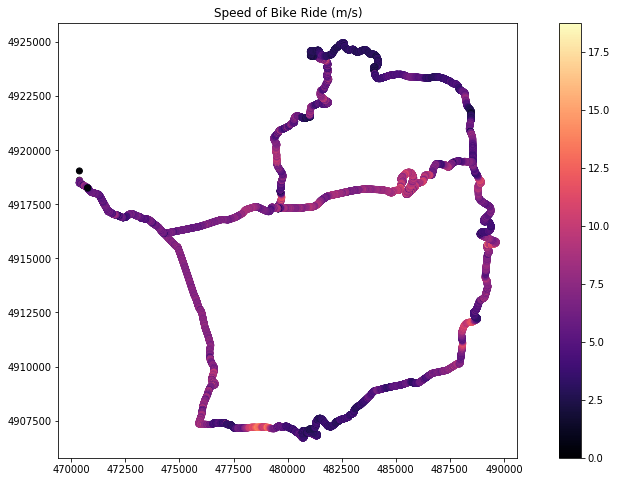

In [11]:
fig, ax = plt.subplots(1, figsize=(15, 8))
gdf_m.plot(column="speed", cmap="magma", ax=ax, legend=True)
ax.set_title("Speed of Bike Ride (m/s)")

A lot of this is data wrangling, but now we have location, speed, distance, time, heart rate, elevation, and slope in a geographic format that we can export to whichever format we want if we want to drag it into GIS or anything else. We also have the foundation of a dataset that can be used to do some machine learning. Examples of fun things to do include predicting heart rate from speed, elevation, slope or vice versa. 

This notebook is licensed as CC-BY, use and share to your hearts content.